<a href="https://colab.research.google.com/github/baduyne/nlp-zero-to-hero/blob/main/transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TRANSFORMER ARCHITECTURE**

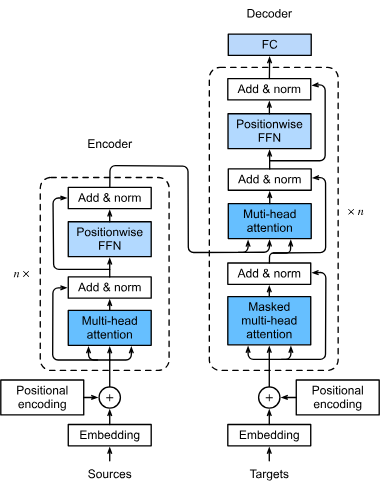

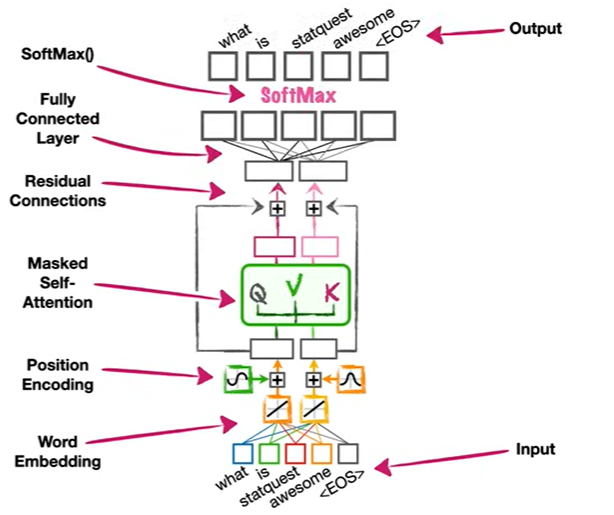

reference:
- article: [https://jalammar.github.io/illustrated-transformer/](https://jalammar.github.io/illustrated-transformer/)
- code:https://github.com/pbcquoc/transformer/blob/master/transformer.ipynb

In [ ]:
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import random
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import math
import os
from tqdm.notebook import tqdm


## **Embedding Layer**

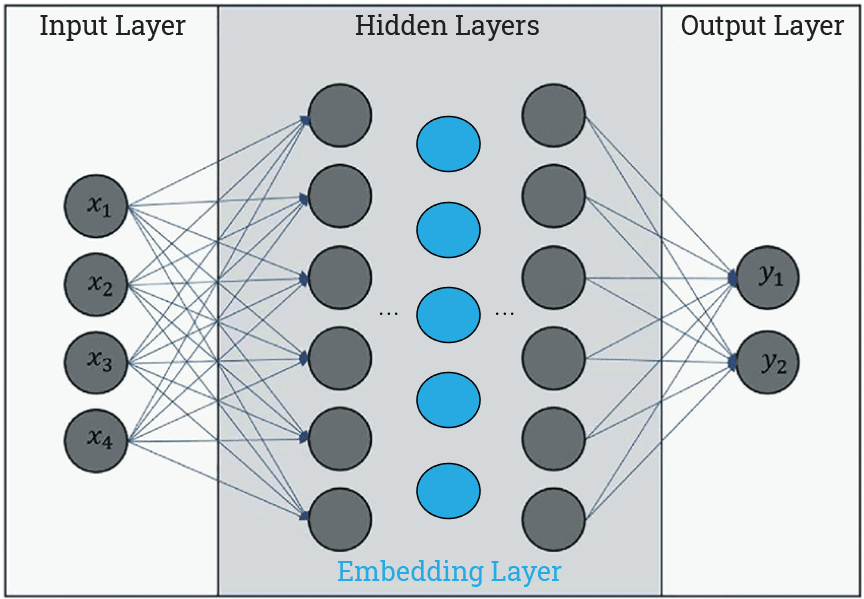

In [ ]:
class Embedding_Layer(nn.Module):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.embedding(x) * math.sqrt(self.d_model)


Cần chuẩn hóa với Embedding quá lớn:
$$ X_{emd} = \frac{X_{emd}}{\sqrt(dmode)}$$

d_model là độ dài của vector embedding

## **Position layer**

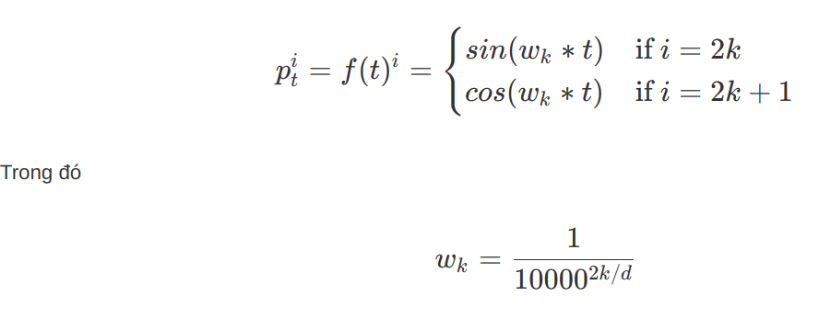

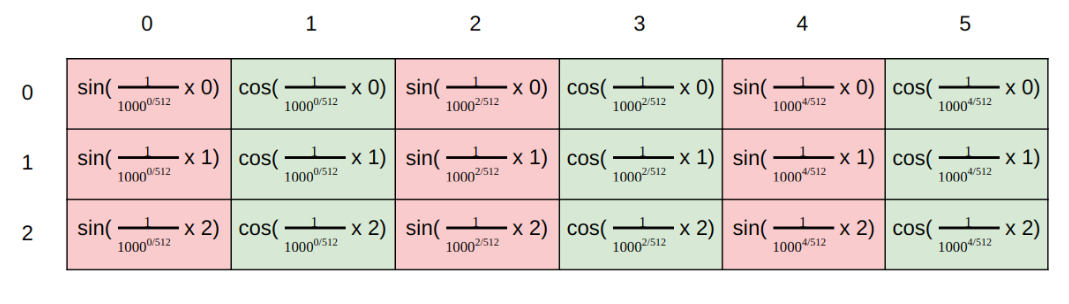

In [ ]:
class Position_Layer(nn.Module):
    def __init__(self, d_model, max_len=200, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

## **Self Attention**

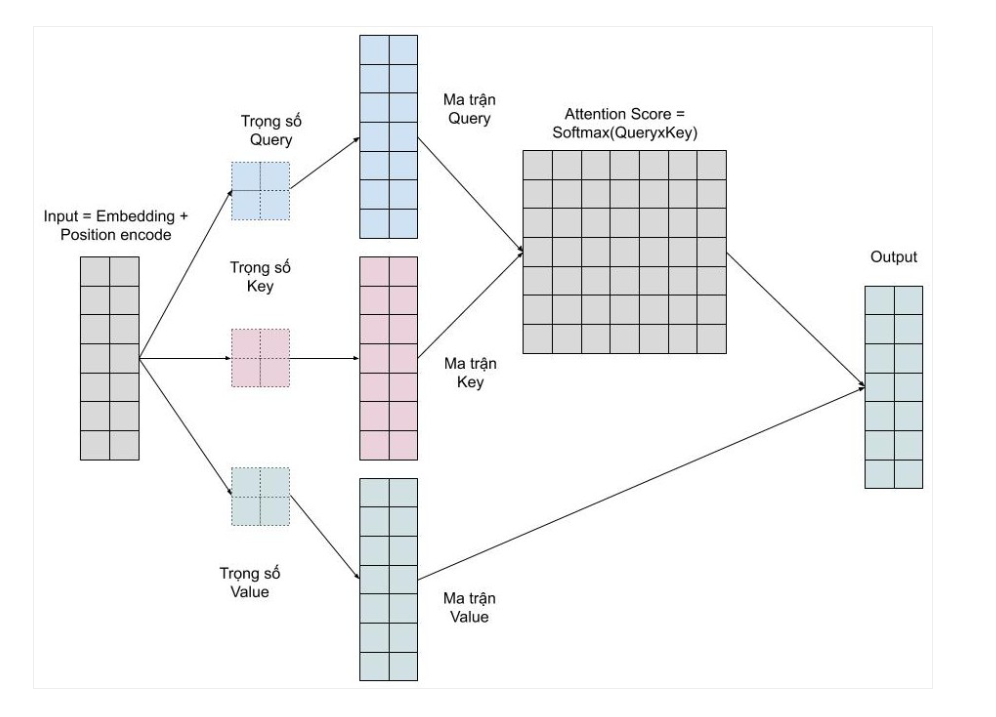

In [ ]:
def self_attention(q, k, v, mask=None, dropout=None):
    d_k = q.size(-1)
    scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)

    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)

    p_attn = F.softmax(scores, dim=-1)

    if dropout is not None:
        p_attn = dropout(p_attn)

    return torch.matmul(p_attn, v), p_attn



## **MultiHead Attention**

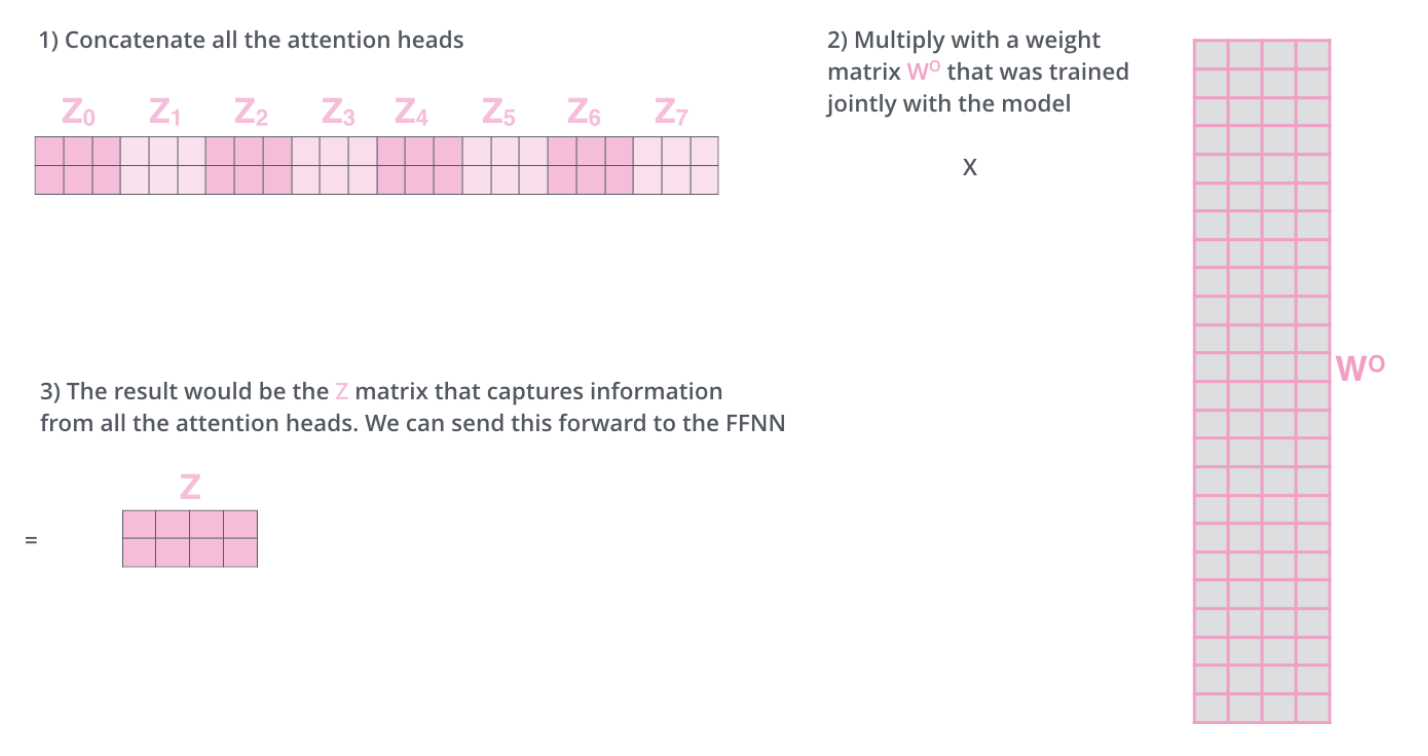

Nhân 1 ma trận với 1 layer, có thể hiểu nom na như này: W chính là trọng số của output_chanel

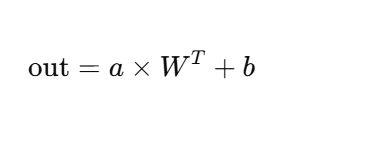

In [ ]:
# Multi-Head Attention
class Multihead_attention(nn.Module):
    def __init__(self, head, d_model, dropout=0.1):
        super().__init__()
        assert d_model % head == 0
        self.d_k = d_model // head
        self.h = head

        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)

        # Linear projections
        q = self.q_linear(q).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
        k = self.k_linear(k).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
        v = self.v_linear(v).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)

        # Adjust mask shape
        if mask is not None:
            # mask: [batch_size, 1, 1, seq_len] -> [batch_size, h, seq_len, seq_len]
            mask = mask.unsqueeze(1)  # Add head dimension
            # This ensures it can be broadcasted over attention scores

        # Calculate attention
        scores, attn = self_attention(q, k, v, mask=mask, dropout=self.dropout)

        # Concatenate heads
        concat = scores.transpose(1, 2).contiguous().view(batch_size, -1, self.h * self.d_k)

        # Final linear layer
        output = self.out(concat)
        return output

## **Norm Layer**

In [ ]:
class Norm(nn.Module):
    def __init__(self, d_model, eps=1e-6):
        super().__init__()
        self.a = nn.Parameter(torch.ones(d_model))
        self.b = nn.Parameter(torch.zeros(d_model))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a * (x - mean) / (std + self.eps) + self.b


In [ ]:
class FeedForward(nn.Module):
    """ Trong kiến trúc của chúng ta có tầng linear
    """
    def __init__(self, d_model, d_ff=2048, dropout = 0.1):
        super().__init__()

        # We set d_ff as a default to 2048
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        x = self.dropout(F.relu(self.linear_1(x)))
        x = self.linear_2(x)
        return x

## **Encoder Layer**

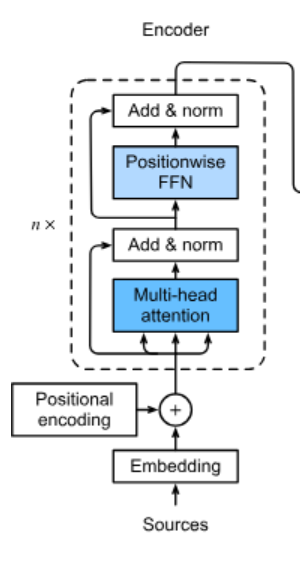

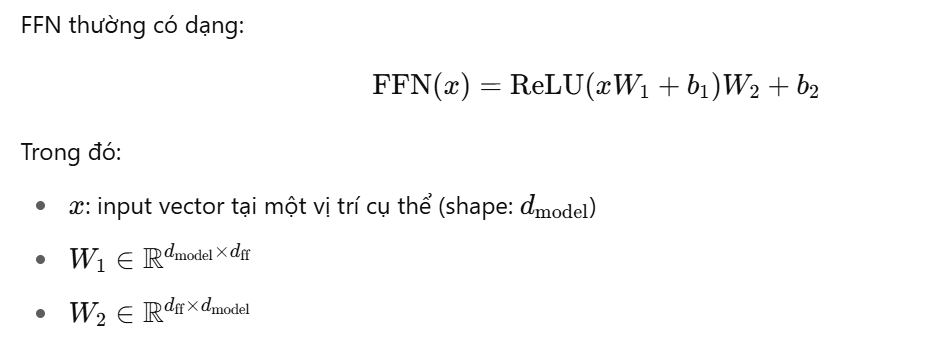

In [ ]:
class Encoder_layer(nn.Module):
    def __init__(self, d_model, head, dropout=0.1):
        super().__init__()
        self.d_model = d_model

        # Layer normalization
        self.norm1 = Norm(d_model)
        self.norm2 = Norm(d_model)

        # Multi-head attention
        self.multi_head = Multihead_attention(head=head, d_model=d_model, dropout=dropout)

        # Feed-forward network
        self.ffn = FeedForward(d_model, dropout=dropout)

        # Dropout layers
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)

    def forward(self, x, mask):
      x2 = self.norm1(x)
      x = x + self.dropout_1(self.multi_head(x2, x2, x2, mask))
      x2 = self.norm2(x)
      x = x + self.dropout_2(self.ffn(x2))
      return x


## **Decoder Layer**

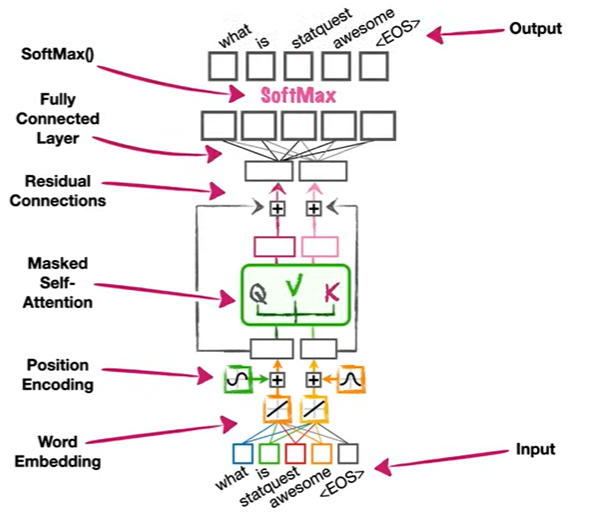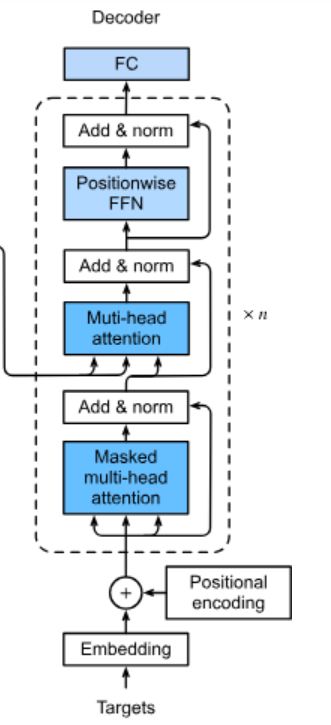

In [ ]:
class Decoder_Layer(nn.Module):
    def __init__(self, d_model, head, dropout=0.1):
        super().__init__()
        self.d_model = d_model

        # 3 norm layers
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.norm_3 = Norm(d_model)

        # 3 dropout layers
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        self.dropout_3 = nn.Dropout(dropout)

        # 2 multi-head attention blocks
        self.attn_1 = Multihead_attention(head, d_model, dropout=dropout)  # ✅ fix cú pháp thiếu dấu phẩy
        self.attn_2 = Multihead_attention(head, d_model, dropout=dropout)

        # Feedforward network
        self.ffn = FeedForward(d_model, dropout=dropout)

    def forward(self, x, encoder_output, src_mask, trg_mask):
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.attn_1(x2, x2, x2, trg_mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.attn_2(x2, encoder_output, encoder_output, src_mask))
        x2 = self.norm_3(x)
        x = x + self.dropout_3(self.ffn(x2))
        return x


## **Encoder**

In [ ]:
import copy

def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

class Encoder(nn.Module):
    """Một encoder có nhiều encoder layer nhé !!!
    """
    def __init__(self, vocab_size, d_model, N, heads, dropout):
        super().__init__()
        self.N = N
        self.embed = Embedding_Layer(vocab_size, d_model)
        self.pe = Position_Layer(d_model, dropout=dropout)
        self.layers = get_clones(Encoder_layer(d_model, heads, dropout), N)
        self.norm = Norm(d_model)

    def forward(self, src, mask):
        """
        src: batch_size x seq_length
        mask: batch_size x 1 x seq_length
        output: batch_size x seq_length x d_model
        """
        x = self.embed(src)
        x = self.pe(x)
        for i in range(self.N):
            x = self.layers[i](x, mask)
        return self.norm(x)

# Encoder(232, 512,6,8,0.1)(torch.LongTensor(32, 30).random_(0, 10), torch.rand(32, 1, 30)).shape

## **Decoder**

In [ ]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads, dropout):
        super().__init__()
        self.N = N
        self.embed = Embedding_Layer(vocab_size, d_model)
        self.pe = Position_Layer(d_model, dropout=dropout)
        self.layers = get_clones(Decoder_Layer(d_model, heads, dropout), N)
        self.norm = Norm(d_model)

    def forward(self, trg, e_outputs, src_mask, trg_mask):
        x = self.embed(trg)
        x = self.pe(x)
        for i in range(self.N):
            x = self.layers[i](x, e_outputs, src_mask, trg_mask)
        return self.norm(x)


## **Transformer**

In [ ]:
# Transformer Model
class Transformer(nn.Module):
    def __init__(self, src_vocab, trg_vocab, d_model, N, heads, dropout):
        super().__init__()
        self.encoder = Encoder(src_vocab, d_model, N, heads, dropout)
        self.decoder = Decoder(trg_vocab, d_model, N, heads, dropout = dropout)
        self.out = nn.Linear(d_model, trg_vocab)

    def forward(self, src, trg, src_mask, trg_mask):
        e_outputs = self.encoder(src, src_mask)
        d_output = self.decoder(trg, e_outputs, src_mask, trg_mask)
        output = self.out(d_output)
        return output

In [ ]:
# Mask functions
def nopeak_mask(size, device):
    np_mask = np.triu(np.ones((1, size, size)), k=1).astype('uint8')
    np_mask = Variable(torch.from_numpy(np_mask) == 0).to(device)
    return np_mask

def create_masks(src, trg, src_pad, trg_pad, device):
    src_mask = (src != src_pad).unsqueeze(-2)

    if trg is not None:
        trg_mask = (trg != trg_pad).unsqueeze(-2)
        size = trg.size(1)
        np_mask = nopeak_mask(size, device)
        trg_mask = trg_mask & np_mask
    else:
        trg_mask = None

    return src_mask, trg_mask


## **Thực hiện**

In [ ]:
# Dataset and DataLoader
class TranslationDataset(Dataset):
    def __init__(self, src_sents, tgt_sents, src_vocab, tgt_vocab, max_len=20):
        self.src = src_sents
        self.tgt = tgt_sents
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.src)

    def __getitem__(self, idx):
        src = self.src[idx]
        tgt = self.tgt[idx]

        src_ids = [self.src_vocab['<sos>']] + [self.src_vocab.get(word, self.src_vocab['<unk>'])
                                              for word in src.lower().split()] + [self.src_vocab['<eos>']]
        tgt_ids = [self.tgt_vocab['<sos>']] + [self.tgt_vocab.get(word, self.tgt_vocab['<unk>'])
                                              for word in tgt.lower().split()] + [self.tgt_vocab['<eos>']]

        # Padding
        src_ids = src_ids[:self.max_len] + [self.src_vocab['<pad>']] * (self.max_len - len(src_ids))
        tgt_ids = tgt_ids[:self.max_len] + [self.tgt_vocab['<pad>']] * (self.max_len - len(tgt_ids))

        return torch.LongTensor(src_ids), torch.LongTensor(tgt_ids)

# Training function
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0

    for i, (src, trg) in enumerate(iterator):
        src = src.to(device)
        trg = trg.to(device)

        optimizer.zero_grad()

        trg_input = trg[:, :-1]
        trg_output = trg[:, 1:]

        src_mask, trg_mask = create_masks(src, trg_input, src_vocab['<pad>'], tgt_vocab['<pad>'], device)

        output = model(src, trg_input, src_mask, trg_mask)

        output_dim = output.shape[-1]
        output = output.contiguous().view(-1, output_dim)
        trg_output = trg_output.contiguous().view(-1)

        loss = criterion(output, trg_output)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

# Example usage
if __name__ == "__main__":
    # Sample data
    src_sents = ["i love you", "how are you", "good night", "thank you", "i am fine"]
    tgt_sents = ["tôi yêu bạn", "bạn khỏe không", "chúc ngủ ngon", "cảm ơn bạn", "tôi khỏe"]

    # Build vocab
    src_words = set()
    tgt_words = set()

    for sent in src_sents:
        src_words.update(sent.lower().split())

    for sent in tgt_sents:
        tgt_words.update(sent.lower().split())

    src_vocab = {'<pad>': 0, '<sos>': 1, '<eos>': 2, '<unk>': 3}
    tgt_vocab = {'<pad>': 0, '<sos>': 1, '<eos>': 2, '<unk>': 3}

    for i, word in enumerate(src_words, start=4):
        src_vocab[word] = i

    for i, word in enumerate(tgt_words, start=4):
        tgt_vocab[word] = i

    # Create dataset and dataloader
    dataset = TranslationDataset(src_sents, tgt_sents, src_vocab, tgt_vocab)
    loader = DataLoader(dataset, batch_size=2, shuffle=True)

    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = Transformer(
        src_vocab=len(src_vocab),
        trg_vocab=len(tgt_vocab),
        d_model=256,
        N=3,
        heads=8,
        dropout=0.1
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
    criterion = nn.CrossEntropyLoss(ignore_index=tgt_vocab['<pad>'])

    # Training loop
    for epoch in range(10):
        train_loss = train(model, loader, optimizer, criterion, clip=1)
        print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3}')

Epoch: 01 | Train Loss: 2.85
Epoch: 02 | Train Loss: 2.7
Epoch: 03 | Train Loss: 2.57
Epoch: 04 | Train Loss: 2.51
Epoch: 05 | Train Loss: 2.31
Epoch: 06 | Train Loss: 2.24
Epoch: 07 | Train Loss: 2.12
Epoch: 08 | Train Loss: 2.02
Epoch: 09 | Train Loss: 2.03
Epoch: 10 | Train Loss: 1.9


In [ ]:
def translate_sentence(sentence, model, src_vocab, tgt_vocab, max_len=20, device='cpu'):
    model.eval()

    # Reverse vocab để lấy từ từ ID
    inv_tgt_vocab = {i: w for w, i in tgt_vocab.items()}

    # Encode input sentence
    tokens = ['<sos>'] + sentence.lower().split() + ['<eos>']
    src_ids = [src_vocab.get(tok, src_vocab['<unk>']) for tok in tokens]
    src_ids = src_ids[:max_len] + [src_vocab['<pad>']] * (max_len - len(src_ids))

    src_tensor = torch.LongTensor(src_ids).unsqueeze(0).to(device)  # (1, max_len)

    # Bắt đầu với token <sos>
    tgt_ids = [tgt_vocab['<sos>']]

    for _ in range(max_len):
        tgt_tensor = torch.LongTensor(tgt_ids).unsqueeze(0).to(device)  # (1, len_so_far)

        # Masks
        src_mask, tgt_mask = create_masks(src_tensor, tgt_tensor, src_vocab['<pad>'], tgt_vocab['<pad>'], device)

        # Model forward
        with torch.no_grad():
            output = model(src_tensor, tgt_tensor, src_mask, tgt_mask)

        next_token = output[0, -1, :].argmax(-1).item()
        tgt_ids.append(next_token)

        # Nếu gặp <eos> thì dừng
        if next_token == tgt_vocab['<eos>']:
            break

    # Chuyển ID -> từ, bỏ <sos> và <eos>
    translated_tokens = [inv_tgt_vocab.get(idx, '<unk>') for idx in tgt_ids[1:] if idx not in [tgt_vocab['<eos>'], tgt_vocab['<pad>']]]
    return ' '.join(translated_tokens)


In [ ]:
sentence = "thank you"

translation = translate_sentence(sentence, model, src_vocab, tgt_vocab, device=device)
print("=> 📘 Dịch: ", translation)

=> 📘 Dịch:  tôi yêu bạn


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# from sklearn.model_selection import train_test_split

# # Tokenization and vocab

# def tokenize(sentence):
#     return sentence.lower().split()

# def build_vocab(sentences, min_freq=2):
#     counter = Counter()
#     for sentence in sentences:
#         counter.update(tokenize(sentence))
#     vocab = {"<pad>": 0, "<sos>": 1, "<eos>": 2, "<unk>": 3}
#     for word, freq in counter.items():
#         if freq >= min_freq:
#             vocab[word] = len(vocab)
#     return vocab

# def encode(sentence, vocab, max_len=100):
#     tokens = ["<sos>"] + tokenize(sentence)[:max_len-2] + ["<eos>"]
#     ids = [vocab.get(tok, vocab["<unk>"]) for tok in tokens]
#     ids += [vocab["<pad>"]] * (max_len - len(ids))
#     return ids

# # Dataset
# class TranslationDataset(Dataset):
#     def __init__(self, src_sentences, tgt_sentences, src_vocab, tgt_vocab, max_len=100):
#         self.src = src_sentences
#         self.tgt = tgt_sentences
#         self.src_vocab = src_vocab
#         self.tgt_vocab = tgt_vocab
#         self.max_len = max_len

#     def __len__(self):
#         return len(self.src)

#     def __getitem__(self, idx):
#         src_ids = encode(self.src[idx], self.src_vocab, self.max_len)
#         tgt_ids = encode(self.tgt[idx], self.tgt_vocab, self.max_len)
#         return torch.tensor(src_ids), torch.tensor(tgt_ids)

# # Load data
# path = "/content/drive/MyDrive/data/"
# with open(os.path.join(path,"train.en"), encoding="utf-8") as f:
#     all_src = f.read().strip().split("\n")

# with open(os.path.join(path,"train.vi"), encoding="utf-8") as f:
#     all_tgt = f.read().strip().split("\n")

# # Build vocab
# src_vocab = build_vocab(all_src)
# tgt_vocab = build_vocab(all_tgt)

# # Train/val split
# train_src, val_src, train_tgt, val_tgt = train_test_split(
#     all_src, all_tgt, test_size=0.1, random_state=42
# )

# # Dataset & Loader
# train_dataset = TranslationDataset(train_src, train_tgt, src_vocab, tgt_vocab)
# val_dataset = TranslationDataset(val_src, val_tgt, src_vocab, tgt_vocab)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32)

# # Device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Model, loss, optimizer
# model = Transformer(
#         src_vocab=len(src_vocab),
#         trg_vocab=len(tgt_vocab),
#         d_model=256,
#         N=3,
#         heads=8,
#         dropout=0.1
#     ).to(device)

# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
# criterion = nn.CrossEntropyLoss(ignore_index=tgt_vocab['<pad>'])

# def train_one_epoch(model, dataloader, optimizer, criterion, clip):
#     model.train()
#     total_loss = 0

#     progress_bar = tqdm(dataloader, leave=True, desc="Training Epoch")
#     for src, tgt in progress_bar:
#         src, tgt = src.to(device), tgt.to(device)
#         tgt_input = tgt[:, :-1]
#         tgt_output = tgt[:, 1:]

#         src_mask, trg_mask = create_masks(src, tgt_input, src_vocab['<pad>'], tgt_vocab['<pad>'], device)

#         output = model(src, tgt_input, src_mask, trg_mask)

#         output_dim = output.shape[-1]
#         output = output.contiguous().view(-1, output_dim)
#         trg_output = tgt_output.contiguous().view(-1)

#         loss = criterion(output, trg_output)
#         loss.backward()

#         torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
#         optimizer.step()
#         optimizer.zero_grad()

#         total_loss += loss.item()

#         # Cập nhật tqdm với loss hiện tại
#         progress_bar.set_postfix({"Batch Loss": loss.item()})

#     return total_loss / len(dataloader)


# def evaluate(model, dataloader, criterion):
#     model.eval()
#     total_loss = 0
#     with torch.no_grad():
#         progress_bar = tqdm(dataloader, leave=True, desc="Evaluating")
#         for src, tgt in progress_bar:
#             src, tgt = src.to(device), tgt.to(device)
#             tgt_input = tgt[:, :-1]
#             tgt_output = tgt[:, 1:]

#             src_mask, trg_mask = create_masks(src, tgt_input, src_vocab['<pad>'], tgt_vocab['<pad>'], device)

#             output = model(src, tgt_input, src_mask, trg_mask)
#             output_dim = output.shape[-1]
#             output = output.contiguous().view(-1, output_dim)
#             trg_output = tgt_output.contiguous().view(-1)

#             loss = criterion(output, trg_output)
#             total_loss += loss.item()

#             progress_bar.set_postfix({"Batch Val Loss": loss.item()})

#     return total_loss / len(dataloader)

In [ ]:
# best_val_loss = float("inf")  # Khởi tạo loss tốt nhất

# num_epochs = 25  # Số epoch train

# for epoch in range(1, num_epochs + 1):
#     train_loss = train_one_epoch(model, train_loader, optimizer, criterion, clip=1)
#     val_loss = evaluate(model, val_loader, criterion)

#     print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

#     # Kiểm tra và lưu mô hình nếu val_loss tốt hơn
#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'val_loss': val_loss
#         }, "best_model.pt")
#         print(f"=> ✅ Model saved at epoch {epoch} with val_loss: {val_loss:.4f}")
#     else:
#         print(f"=> ⚠️ No improvement, model not saved.")


In [ ]:
# Load lại mô hình tốt nhất
checkpoint = torch.load("best_model.pt", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
best_val_loss = checkpoint['val_loss']
start_epoch = checkpoint['epoch']
model.to(device)
model.eval()

print(f"✅ Đã tải mô hình tốt nhất từ epoch {start_epoch} với val_loss = {best_val_loss:.4f}")

# Hàm dịch một câu
def translate_sentence(sentence, model, src_vocab, tgt_vocab, max_len=20, device='cpu'):
    model.eval()
    inv_tgt_vocab = {i: w for w, i in tgt_vocab.items()}

    tokens = ['<sos>'] + sentence.lower().split() + ['<eos>']
    src_ids = [src_vocab.get(tok, src_vocab['<unk>']) for tok in tokens]
    src_ids = src_ids[:max_len] + [src_vocab['<pad>']] * (max_len - len(src_ids))
    src_tensor = torch.LongTensor(src_ids).unsqueeze(0).to(device)

    tgt_ids = [tgt_vocab['<sos>']]

    for _ in range(max_len):
        tgt_tensor = torch.LongTensor(tgt_ids).unsqueeze(0).to(device)
        src_mask, tgt_mask = create_masks(src_tensor, tgt_tensor, src_vocab['<pad>'], tgt_vocab['<pad>'], device)

        with torch.no_grad():
            output = model(src_tensor, tgt_tensor, src_mask, tgt_mask)

        next_token = output[0, -1, :].argmax(-1).item()
        tgt_ids.append(next_token)

        if next_token == tgt_vocab['<eos>']:
            break

    translated_tokens = [inv_tgt_vocab.get(idx, '<unk>') for idx in tgt_ids[1:] if idx not in [tgt_vocab['<eos>'], tgt_vocab['<pad>']]]
    return ' '.join(translated_tokens)




FileNotFoundError: [Errno 2] No such file or directory: 'best_model.pt'

In [ ]:
# Giao diện tương tác
print("\n🌐 Trình dịch Anh -> Việt đang chạy.")
print("💬 Nhập câu tiếng Anh để dịch (gõ 'exit' để thoát)\n")

while True:
    sentence = input("📝 Nhập câu của bạn: ")
    if sentence.strip().lower() == 'exit':
        print("👋 Tạm biệt!")
        break
    translation = translate_sentence(sentence, model, src_vocab, tgt_vocab, device=device)
    print("=> 📘 Dịch: ", translation)
    print("-" * 50)